In [30]:
%load_ext autoreload
%aimport os, pandas, numpy, pickle
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import pandas as pd
ds = pd.read_csv('./trajectory/dataset.csv')
rt = pd.read_csv('./trajectory/ref_traj.csv')

In [15]:
ds.columns

Index(['NLap', 'time', 'isReference', 'is_partial', 'xCarWorld', 'yCarWorld',
       'nYawBody', 'nEngine', 'NGear', 'prevaSteerWheel', 'prevpBrakeF',
       'prevrThrottlePedal', 'positionRho', 'positionTheta',
       'positionReferenceX', 'positionReferenceY', 'positionRelativeX',
       'positionRelativeY', 'referenceCurvature', 'actualCurvature',
       'actualSpeedModule', 'speedDifferenceVectorModule',
       'speedDifferenceOfModules', 'actualAccelerationX',
       'actualAccelerationY', 'referenceAccelerationX',
       'referenceAccelerationY', 'accelerationDiffX', 'accelerationDiffY',
       'aSteerWheel', 'pBrakeF', 'rThrottlePedal'],
      dtype='object')

In [32]:
import pandas as pd
import sys
import os
import pickle
import argparse
from trlib.policies.valuebased import EpsilonGreedy, Softmax
from trlib.policies.qfunction import ZeroQ
from sklearn.ensemble.forest import ExtraTreesRegressor
from trlib.algorithms.reinforcement.fqi_driver import FQIDriver, DoubleFQIDriver
from trlib.environments.trackEnv import TrackEnv
from trlib.utilities.ActionDispatcher import *
from fqi.dataset_preprocessing import *
from fqi.fqi_evaluate import run_evaluation
"""from fqi.et_tuning import run_tuning"""
from fqi.utils import *
from fqi.reward_function import *
from fqi.sars_creator import *
sys.setrecursionlimit(3000)

ref_df = pd.read_csv('./trajectory/ref_traj.csv')
data_df = pd.read_csv('./trajectory/dataset.csv')

In [17]:
state_cols

['xCarWorld',
 'yCarWorld',
 'nYawBody',
 'nEngine',
 'positionRho',
 'positionTheta',
 'referenceCurvature',
 'actualCurvature',
 'actualSpeedModule',
 'speedDifferenceVectorModule',
 'actualAccelerationX',
 'actualAccelerationY',
 'referenceAccelerationX',
 'referenceAccelerationY',
 'accelerationDiffX',
 'accelerationDiffY',
 'prevaSteerWheel',
 'prevpBrakeF',
 'prevrThrottlePedal']

In [33]:
def run_experiment(track_file_name, rt_file_name, data_path, max_iterations, output_path, n_throttle,
               n_brake, n_steer, n_jobs, output_name, reward_function, delta_t,
               filter_actions, ad_type, tuning, kdt_norm, kdt_param, filt_a_outliers, double_fqi, evaluation,
                  r_penalty, first_step):
    
    print('Training with',reward_function , 'reward function')

    # instantiate Reward Function and build SARS
    if r_penalty:
        penalty = LikelihoodPenalty()
        if reward_function == 'speed':
            reward_function = Speed_projection(ref_df)
        elif reward_function == 'spatial':
            reward_function = Spatial_projection(ref_df)
        elif reward_function == 'temporal':
            reward_function = Temporal_projection(ref_df)
        elif reward_function == 'curv':
            reward_function = Curv_temporal(ref_df)
    else:
        if reward_function == 'speed':
            reward_function = Speed_projection(ref_df)
        elif reward_function == 'spatial':
            reward_function = Spatial_projection(ref_df)
        elif reward_function == 'temporal':
            reward_function = Temporal_projection(ref_df)
        elif reward_function == 'curv':
            reward_function = Curv_temporal(ref_df)
            
    sars_data = to_SARS(data_df, reward_function)
    print('SARS prepared')
    
    
    nmin = 5
    # Create environment
    state_dim = len(state_cols)
    action_dim = len(action_cols)
    mdp = TrackEnv(state_dim, action_dim, 0.99999, 'continuous')

    # Parameters of ET regressor
    regressor_params = {'n_estimators': 100,
                        'criterion': 'mse',
                        'min_samples_split': 2,
                        'min_samples_leaf': nmin,
                        'n_jobs': n_jobs,
                        'random_state': 42}
    regressor = ExtraTreesRegressor

    if ad_type == 'fkdt':
        action_dispatcher = FixedKDTActionDispatcher
        alg_actions = sars_data[action_cols].values

    elif ad_type == 'rkdt':
        action_dispatcher = RadialKDTActionDispatcher
        alg_actions = sars_data[action_cols].values

    elif ad_type == 'discrete':
        action_dispatcher = ConstantActionDispatcher
        actions, sub_actions = create_action_combinations(sars_data, n_throttle, n_brake, n_steer, filter_actions)
        alg_actions = sub_actions
    else:
        action_dispatcher = None
        alg_actions = None

    # Create policy instance
    if first_step:
        """epsilon = 0  # no exploration
        pi = EpsilonGreedy([], ZeroQ(), epsilon)"""
        temperature = 0.5  # no exploration
        pi = Softmax([], ZeroQ(), temperature)
    else:
        # import policy
        algorithm_name = output_name + '.pkl'
        policy_name = 'policy_' + algorithm_name
        with open(output_path + '/' + policy_name, 'rb') as pol:
            print('loading policy')
            pi = pickle.load(pol)
            print('pi:', pi)

    # Define the order of the columns to pass to the algorithm
    # state_prime_cols: colonne dello stato successivo
    cols = ['t'] + state_cols + action_cols + ['r'] + state_prime_cols + ['absorbing']
    # Define the masks used by the action dispatcher
    state_mask = [i for i, s in enumerate(state_cols) if s in knn_state_cols]
    data_mask = [i for i, c in enumerate(cols) if c in knn_state_cols]

    if double_fqi:
        fqi = DoubleFQIDriver
    else:
        fqi = FQIDriver

    algorithm = fqi(mdp=mdp,
                    policy=pi,
                    actions=alg_actions,
                    max_iterations=max_iterations,
                    regressor_type=regressor,
                    data=sars_data[cols].values,
                    action_dispatcher=action_dispatcher,
                    state_mask=state_mask,
                    data_mask=data_mask,
                    s_norm=kdt_norm,
                    filter_a_outliers=filt_a_outliers,
                    ad_n_jobs=n_jobs,
                    ad_param=kdt_param,
                    verbose=True,
                    **regressor_params)

    result = algorithm.step()
    

    # save algorithm object
    algorithm_name = output_name + '.pkl'
    with open(output_path + '/' + algorithm_name, 'wb') as output:
        pickle.dump(algorithm, output, pickle.HIGHEST_PROTOCOL)
    print('Saved algorithm object')
    
    # save policy object
    policy_name = 'policy_' + algorithm_name
    with open(output_path + '/' + policy_name, 'wb') as output:
        pickle.dump(algorithm._policy, output, pickle.HIGHEST_PROTOCOL)
    print('Saved policy object')

    # save action dispatcher object
    AD_name = 'AD_' + algorithm_name
    with open(output_path + '/' + AD_name, 'wb') as output:
        pickle.dump(algorithm._action_dispatcher, output, pickle.HIGHEST_PROTOCOL)
    print('Saved Action Dispatcher')
    
    

    if evaluation:

        print('*** Evaluation ***')
        run_evaluation(output_path+'/'+algorithm_name, track_file_name, data_path, n_jobs, output_path,
                       'eval_'+output_name, filter_actions,
                       output_path + '/' + AD_name)



In [23]:
track_file_name = 'dataset'
rt_file_name = 'ref_traj'
data_path = './trajectory/'
max_iterations = 100
output_path = './model_file/'
n_jobs = 3

reward_function = 'speed'
output_name = reward_function + '_reward_model'#'first_model'

filter_actions = False
filt_a_outliers = False
evaluation = True


In [24]:
run_experiment(track_file_name, rt_file_name, data_path, max_iterations, output_path, 3,3,3, n_jobs, output_name, 
               reward_function, 2, filter_actions, 'rkdt', False, False, 10, filt_a_outliers, True, evaluation)
#run_experiment('dataset', 'ref_traj', './trajectory/', 100, './model_file/', 3,3,3, 10, 'pippo', 'progress', 2, False, 'rkdt', False, False, 10, False, True, True)
#run_experiment('dataset', 'ref_traj', './trajectory/', 100, './model_file/', 3,3,3, 10, output_name, reward_function, 2, False, 'rkdt', False, False, 10, False, True, True)

SARS prepared
Step 1
Finding nearest actions for each state prime
Time for action list 2.665055274963379
Time for action set 0.5593063831329346
Time for sprime a mat 7.780272960662842
Iteration 0
fitQ 6.7604453563690186
Elapsed time 6.7604453563690186
Iteration 1
maxQ 10.631462574005127
fitQ 6.320966482162476
Elapsed time 16.952429056167603
Iteration 2
maxQ 11.050742864608765
fitQ 6.480396509170532
Elapsed time 17.531139373779297
Iteration 3
maxQ 11.359262943267822
fitQ 6.379650354385376
Elapsed time 17.7389132976532
Iteration 4
maxQ 10.69969367980957
fitQ 6.813989162445068
Elapsed time 17.51368284225464
Iteration 5
maxQ 11.685628175735474
fitQ 6.527428388595581
Elapsed time 18.213056564331055
Iteration 6
maxQ 10.097771644592285
fitQ 6.56108546257019
Elapsed time 16.658857107162476
Iteration 7
maxQ 10.143290758132935
fitQ 6.166327953338623
Elapsed time 16.309618711471558
Iteration 8
maxQ 9.935208797454834
fitQ 6.8811423778533936
Elapsed time 16.816351175308228
Iteration 9
maxQ 11.46106

maxQ 9.559775590896606
fitQ 5.465796709060669
Elapsed time 15.025572299957275
Iteration 89
maxQ 8.870228290557861
fitQ 5.288315534591675
Elapsed time 14.158543825149536
Iteration 90
maxQ 8.689584016799927
fitQ 5.174652814865112
Elapsed time 13.864236831665039
Iteration 91
maxQ 9.021187543869019
fitQ 5.3286871910095215
Elapsed time 14.34987473487854
Iteration 92
maxQ 8.681641101837158
fitQ 5.1684393882751465
Elapsed time 13.850080490112305
Iteration 93
maxQ 8.574977397918701
fitQ 5.6938910484313965
Elapsed time 14.268868446350098
Iteration 94
maxQ 9.66672420501709
fitQ 5.68028998374939
Elapsed time 15.34701418876648
Iteration 95
maxQ 10.244715929031372
fitQ 5.669517517089844
Elapsed time 15.914233446121216
Iteration 96
maxQ 9.366435527801514
fitQ 5.509487152099609
Elapsed time 14.875922679901123
Iteration 97
maxQ 9.484494686126709
fitQ 5.616286754608154
Elapsed time 15.100781440734863
Iteration 98
maxQ 9.962992429733276
fitQ 6.357186794281006
Elapsed time 16.320179224014282
Iteration 99

In [ ]:
track_file_name = 'dataset'
rt_file_name = 'ref_traj'
data_path = './trajectory/'
max_iterations = 100
output_path = './model_file/'
n_jobs = 3

filter_actions = False
filt_a_outliers = False
evaluation = True

for reward_function in ['speed', 'spatial', 'temporal']:
    output_name = reward_function + '_reward_model'#'first_model'
    run_experiment(track_file_name, rt_file_name, data_path, max_iterations, output_path, 3,3,3, n_jobs, output_name, 
               reward_function, 2, filter_actions, 'rkdt', False, False, 10, filt_a_outliers, True, evaluation)

Training with speed reward function
SARS prepared
Step 1
Finding nearest actions for each state prime
Time for action list 3.585146188735962
Time for action set 0.5479140281677246
Time for sprime a mat 9.745897769927979
Iteration 0
fitQ 7.4454240798950195
Elapsed time 7.4454240798950195
Iteration 1
maxQ 17.811928510665894
fitQ 7.371379137039185
Elapsed time 25.183307647705078
Iteration 2
maxQ 18.076987504959106
fitQ 7.495467901229858
Elapsed time 25.572455406188965
Iteration 3
maxQ 16.926363706588745
fitQ 7.2884039878845215
Elapsed time 24.214767694473267
Iteration 4
maxQ 18.46100878715515
fitQ 7.2772650718688965
Elapsed time 25.738273859024048
Iteration 5
maxQ 17.553853273391724
fitQ 7.350776195526123
Elapsed time 24.904629468917847
Iteration 6
maxQ 17.83598518371582
fitQ 7.5830748081207275
Elapsed time 25.419059991836548
Iteration 7
maxQ 17.159972667694092
fitQ 7.604495525360107
Elapsed time 24.7644681930542
Iteration 8
maxQ 17.61659002304077
fitQ 8.103679418563843
Elapsed time 25.72

In [6]:
algorithm_name = output_name + '.pkl'
AD_name = 'AD_' + algorithm_name
run_evaluation(output_path+'/'+algorithm_name, track_file_name, data_path, n_jobs, output_path,
                       'eval_'+output_name, filter_actions, output_path + '/' + AD_name)

Processing 1.0 of 50
Computed pilot Q values
Computing policy Q values
Processing 2.0 of 50
Computed pilot Q values
Computing policy Q values
Processing 3.0 of 50
Computed pilot Q values
Computing policy Q values
Processing 4.0 of 50
Computed pilot Q values
Computing policy Q values
Processing 5.0 of 50
Computed pilot Q values
Computing policy Q values
Processing 6.0 of 50
Computed pilot Q values
Computing policy Q values
Processing 7.0 of 50
Computed pilot Q values
Computing policy Q values
Processing 8.0 of 50
Computed pilot Q values
Computing policy Q values
Processing 9.0 of 50
Computed pilot Q values
Computing policy Q values
Processing 10.0 of 50
Computed pilot Q values
Computing policy Q values
Processing 11.0 of 50
Computed pilot Q values
Computing policy Q values
Processing 12.0 of 50
Computed pilot Q values
Computing policy Q values
Processing 13.0 of 50
Computed pilot Q values
Computing policy Q values
Processing 14.0 of 50
Computed pilot Q values
Computing policy Q values
P

In [7]:
from fqi.result_plot import *

In [8]:
import pickle
with open('./model_file/eval_first_model.pkl', 'rb') as e:
    evaluation = pickle.load(e)

In [9]:
evaluation

{1.0: [array([-1.01967878e+00, -1.01063616e+00, -9.32432359e-01, -8.27334633e-01,
         -8.23008428e-01, -8.83471792e-01, -9.49691737e-01, -9.34639192e-01,
         -9.73960348e-01, -1.02911418e+00, -1.04002490e+00, -1.09945415e+00,
         -1.15403654e+00, -1.17543115e+00, -1.30817203e+00, -1.19407881e+00,
         -1.29556749e+00, -1.51440055e+00, -1.59376352e+00, -1.62189734e+00,
         -1.67590464e+00, -1.21373648e+00, -1.17198488e+00, -1.14415255e+00,
         -1.19262240e+00, -1.08583301e+00, -1.05222302e+00, -1.02341935e+00,
         -1.02035432e+00, -9.79142434e-01, -9.30190204e-01, -7.21754470e-01,
         -5.94806278e-01, -2.81159166e-01,  7.28926159e-02,  4.01572248e-01,
          6.96197760e-01,  9.91120641e-01,  1.35729888e+00,  1.71431170e+00,
          1.94386186e+00,  2.37604460e+00,  2.84476251e+00,  3.22630702e+00,
          3.64013987e+00,  4.10023367e+00,  4.51601402e+00,  4.93002971e+00,
          5.32509885e+00,  5.81150447e+00,  6.15049433e+00,  6.49107393

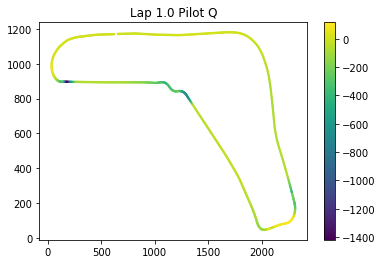

In [12]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(1,1)
plot_q(1.0, ds, evaluation, f, ax, 'policy', save_fig=False, path='./')

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


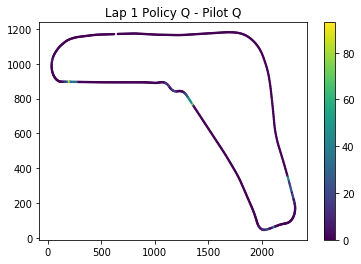

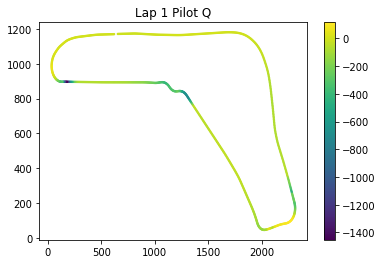

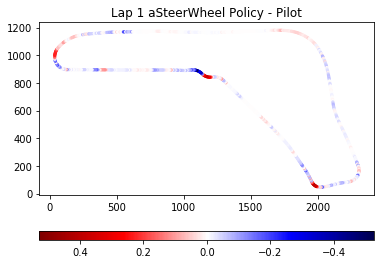

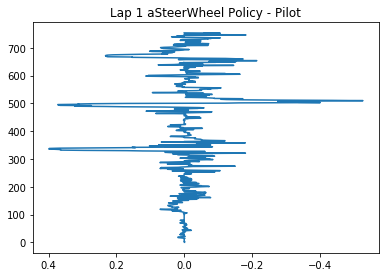

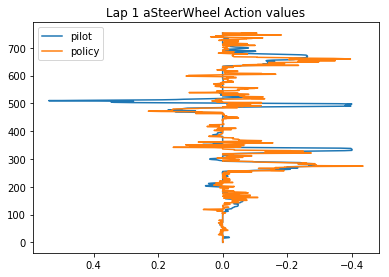

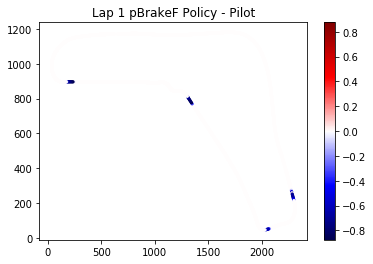

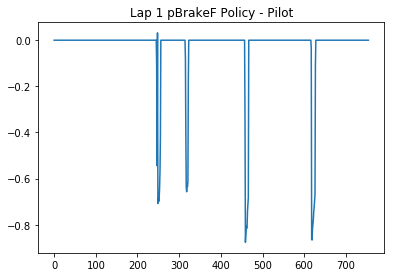

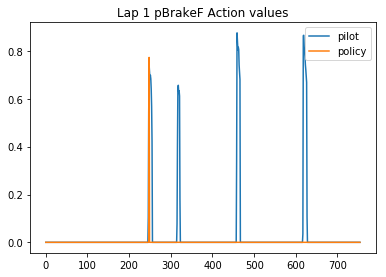

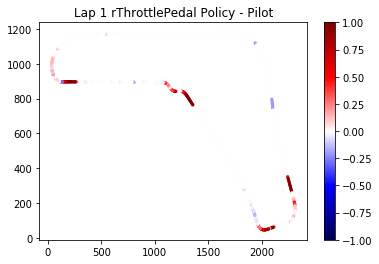

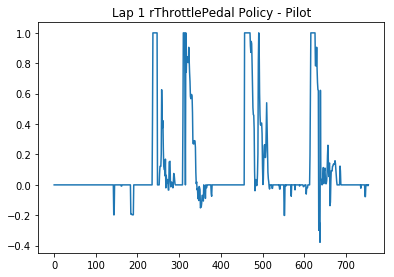

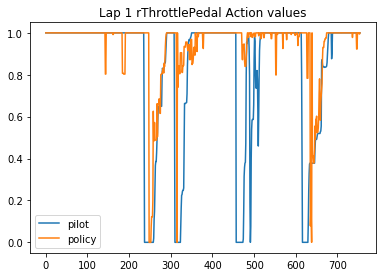

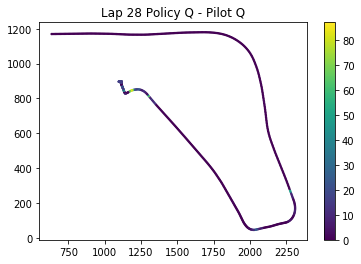

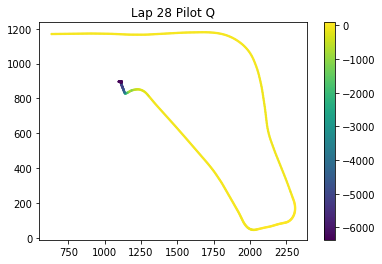

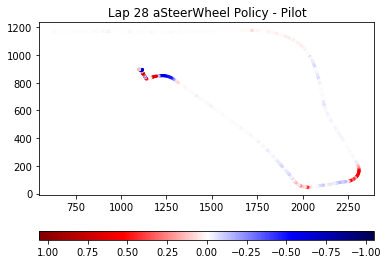

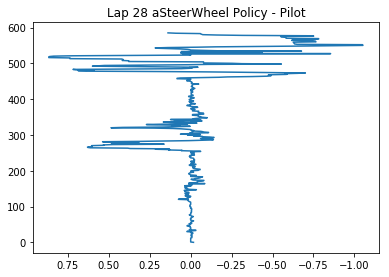

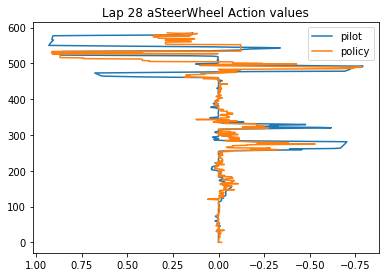

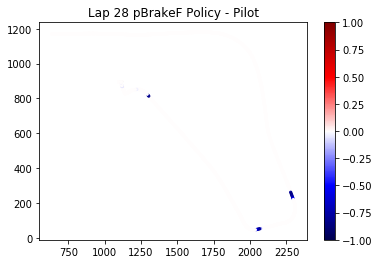

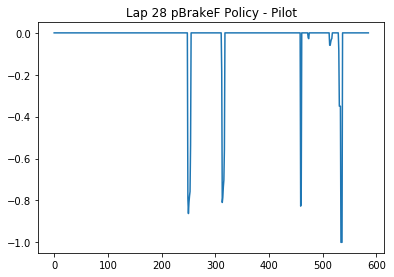

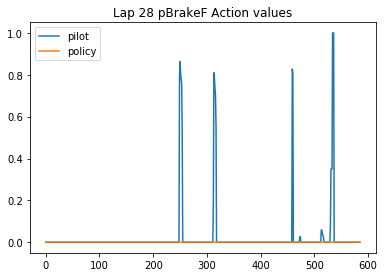

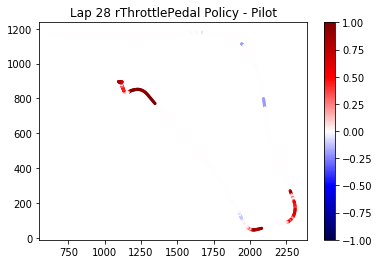

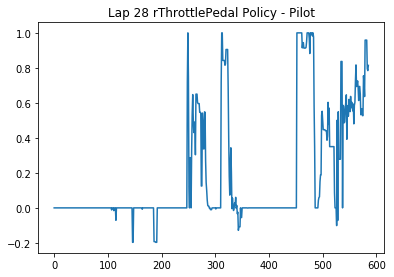

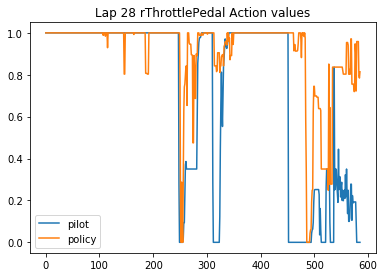

In [22]:
laps = list(evaluation.keys())
laps_to_analyse = [1, 28]
for lap in laps_to_analyse:
    f, ax = plt.subplots(1,1)
    plot_q_delta(lap, ds, evaluation, f, ax)
    f, ax = plt.subplots(1,1)
    plot_q(lap, ds, evaluation, f, ax, 'pilot')
    for i in range(len(action_cols)):
        f, ax = plt.subplots(1,1)
        plot_action_delta(lap, i, ds, evaluation, f, ax)

In [16]:
with open(os.path.join('model_file/first_model.pkl'), 'rb') as a:
    alg = pickle.load(a)
    
et_A = alg._policy.Q._regressor[0]
et_B = alg._policy.Q._regressor[1]
variables = state_cols + action_cols

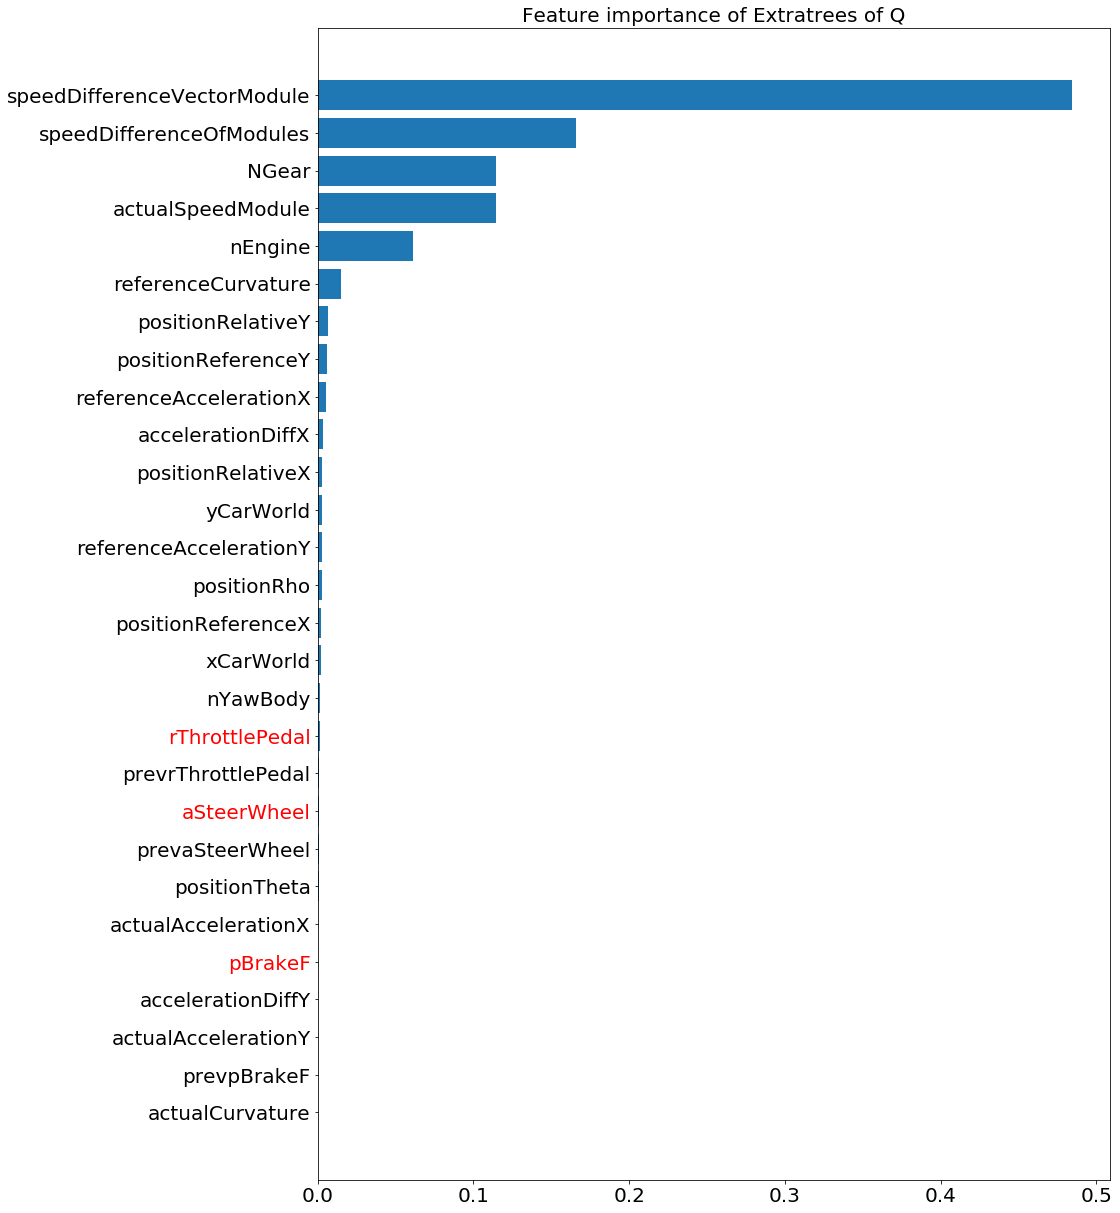

In [17]:
plot_feature_importance(variables, et_A.feature_importances_)

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


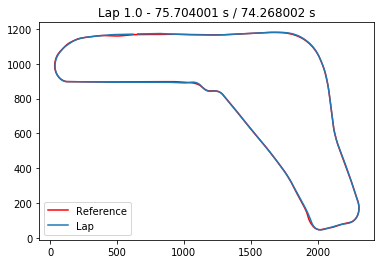

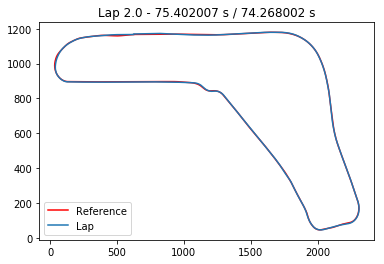

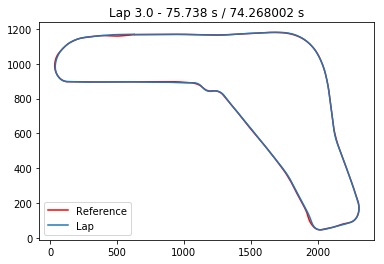

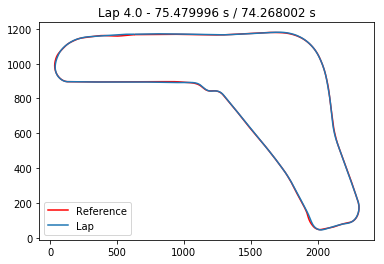

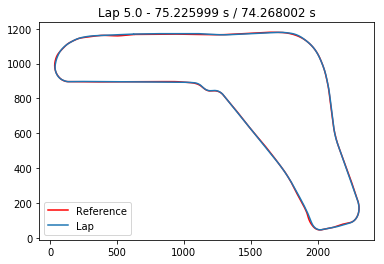

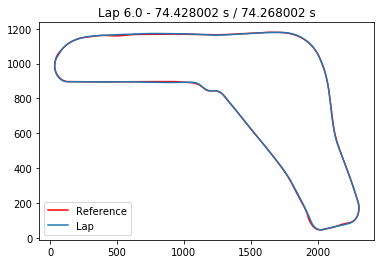

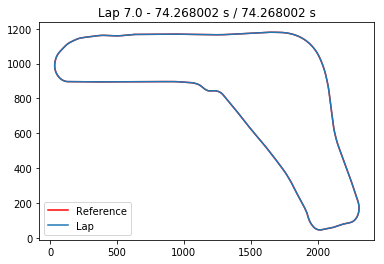

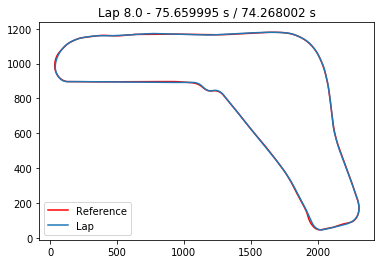

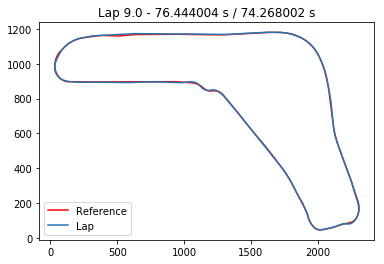

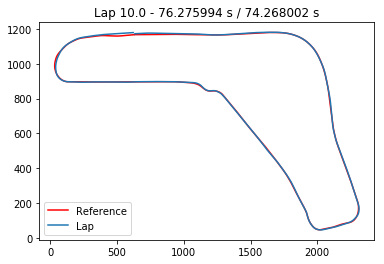

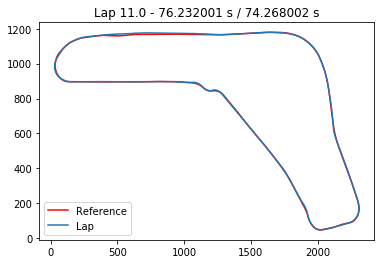

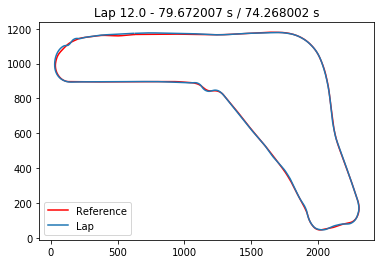

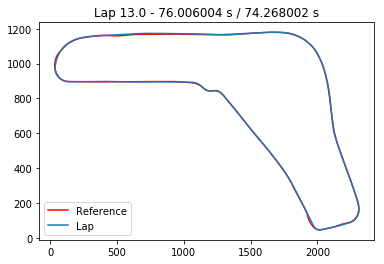

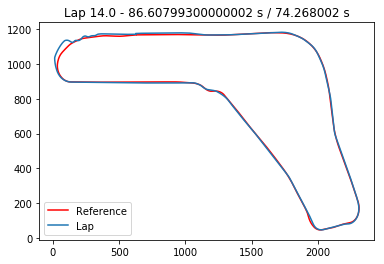

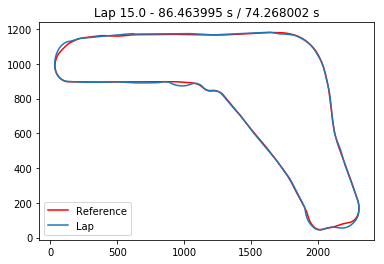

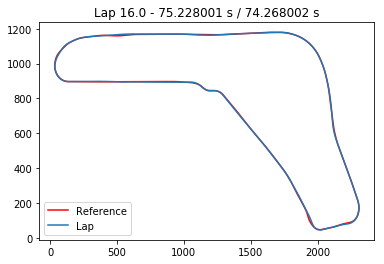

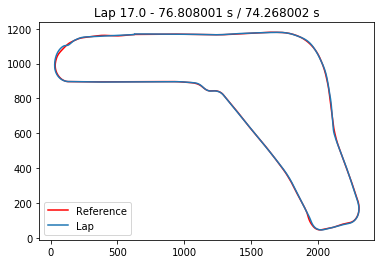

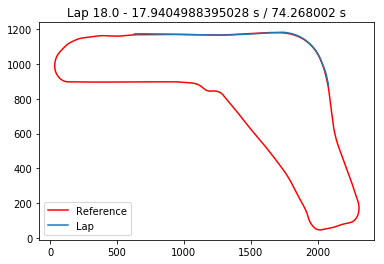

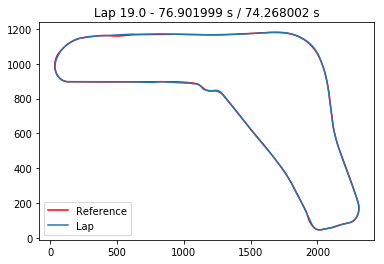

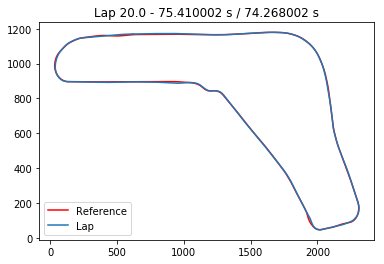

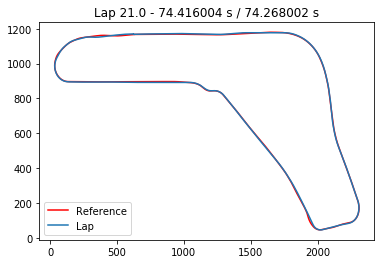

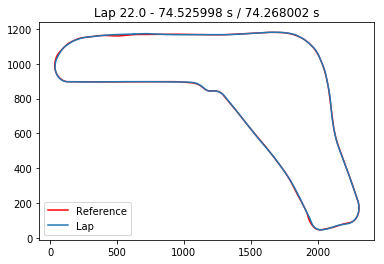

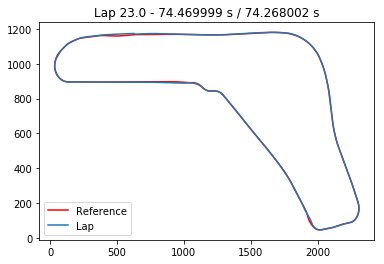

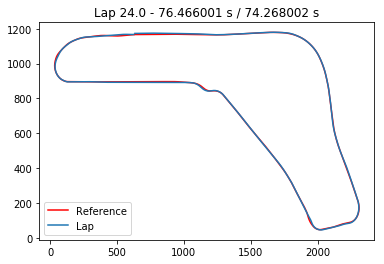

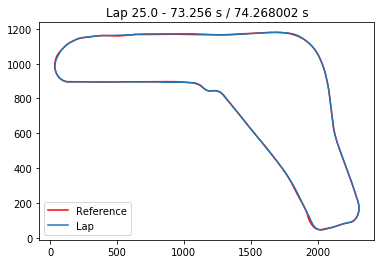

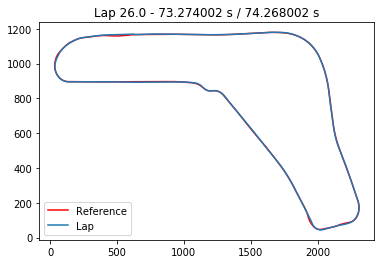

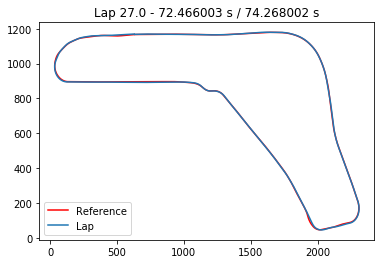

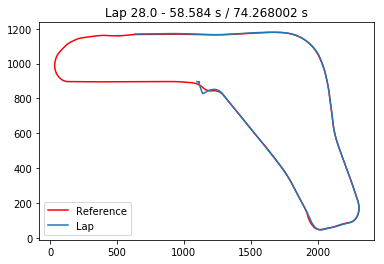

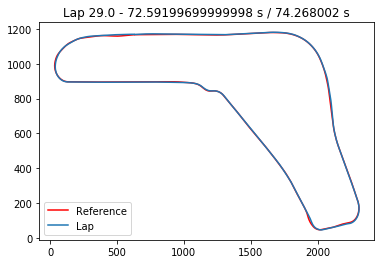

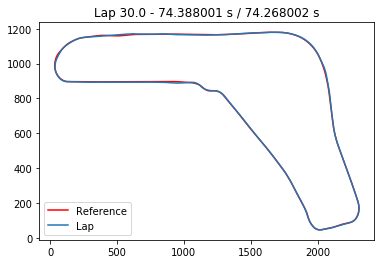

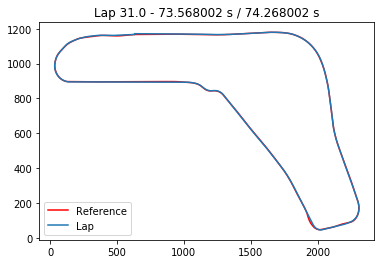

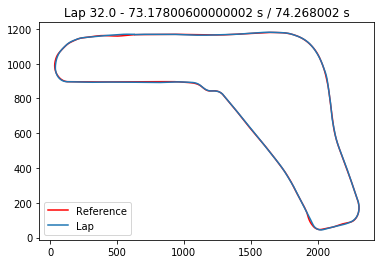

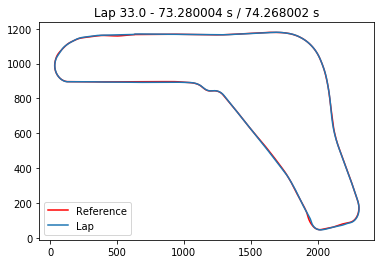

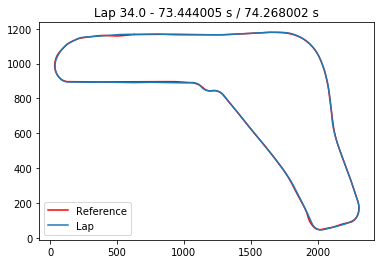

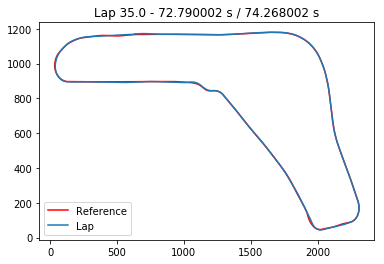

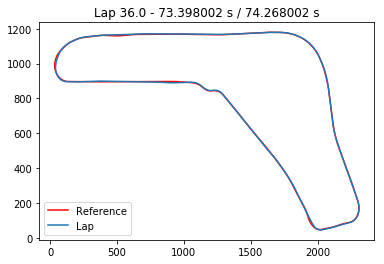

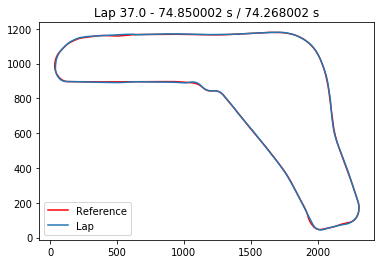

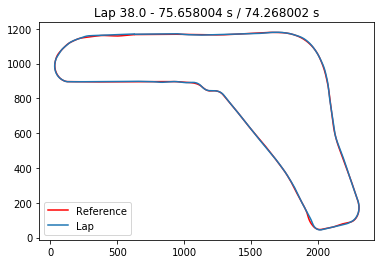

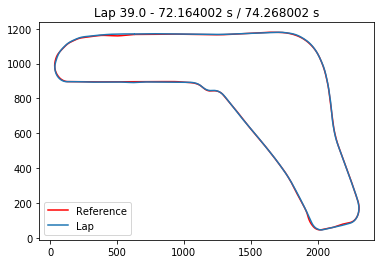

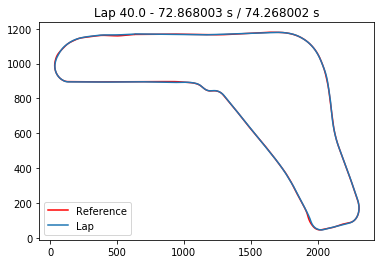

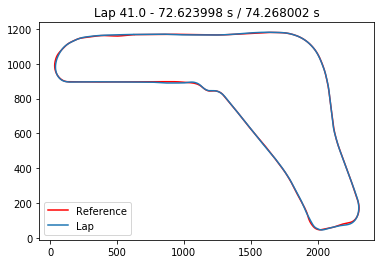

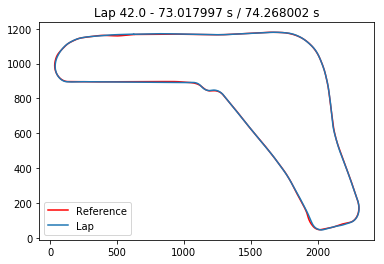

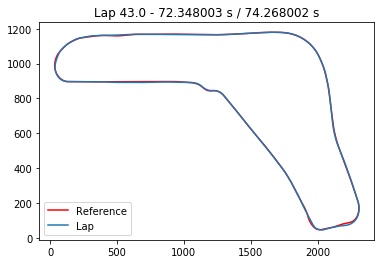

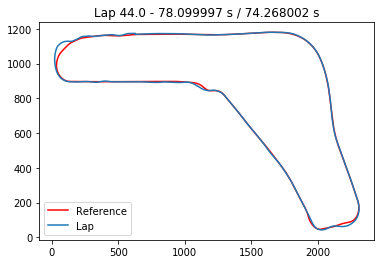

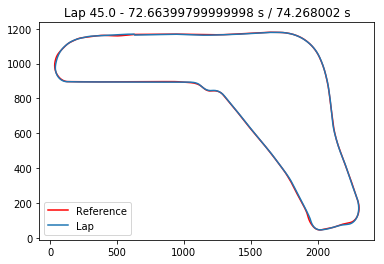

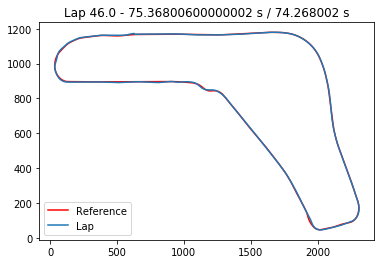

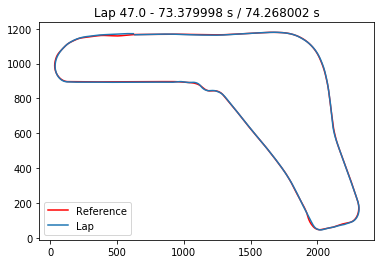

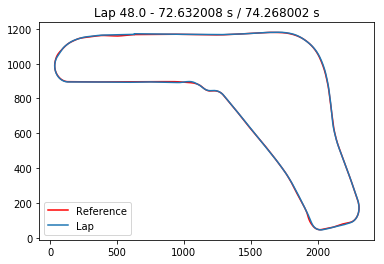

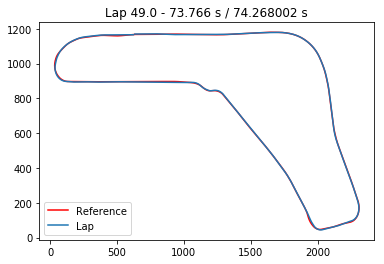

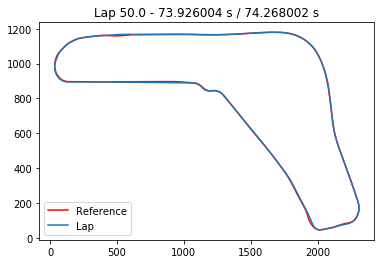

In [18]:
laps = list(evaluation.keys())
for lap in laps:
    f, ax = plt.subplots(1,1)
    plot_trajectories(ds, lap, f, ax, ds[ds.NLap == 7])